# Weather Data ETL Pipeline

This notebook demonstrates a live ETL (Extract, Transform, Load) pipeline using weather data from the OpenWeatherMap API for Hyderabad, India.

In [13]:
import json
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Extract

Fetch weather forecast data from the OpenWeatherMap API.

In [17]:
api_key="b7f99b938c9095264d2ecc258dfc26d6"
a_k=api_key
city="Hyderabad,India"
url=f"http://api.openweathermap.org/data/2.5/forecast?q={city}&cnt=240&appid={api_key}"
response=requests.get(url)

In [18]:
data =response.json()
json_str=json.dumps(data,indent=4)
print(json_str)

{
    "cod": "200",
    "message": 0,
    "cnt": 40,
    "list": [
        {
            "dt": 1756479600,
            "main": {
                "temp": 298.6,
                "feels_like": 299.5,
                "temp_min": 298.6,
                "temp_max": 298.6,
                "pressure": 1007,
                "sea_level": 1007,
                "grnd_level": 944,
                "humidity": 88,
                "temp_kf": 0
            },
            "weather": [
                {
                    "id": 802,
                    "main": "Clouds",
                    "description": "scattered clouds",
                    "icon": "03n"
                }
            ],
            "clouds": {
                "all": 35
            },
            "wind": {
                "speed": 3.57,
                "deg": 255,
                "gust": 8.51
            },
            "visibility": 10000,
            "pop": 0,
            "sys": {
                "pod": "n"
            },
           

## Transform

Clean, process, and visualize the weather data.

In [19]:
def k_to_c(temp_k):
    return temp_k-273.15

In [20]:
if response.status_code == 200:
    data = response.json()
    weather_data = []

    for hour in data['list']:
        date_time = datetime.utcfromtimestamp(hour['dt']).strftime('%Y-%m-%d %H:%M:%S')
        temp = k_to_c(hour['main']['temp'])
        feels_like = k_to_c(hour['main']['feels_like'])
        pressure = hour['main']['pressure']
        humidity = hour['main']['humidity']
        
        weather_main = hour['weather'][0]['main']
        weather_description = hour['weather'][0]['description']
        
        wind_speed = hour['wind']['speed']
        wind_direction = hour['wind']['deg']
        
        cloudiness = hour['clouds']['all']
        
        rain_volume = hour.get('rain', {}).get('3h', 0)   # safe lookup
        snow_volume = hour.get('snow', {}).get('3h', 0)   # safe lookup

        # Save results in list (optional, depends on your use case)
        weather_data.append({
            "date_time": date_time,
            "temperature": temp,
            "feels_like": feels_like,
            "pressure": pressure,
            "humidity": humidity,
            "weather": weather_main,
            "description": weather_description,
            "wind_speed": wind_speed,
            "wind_direction": wind_direction,
            "cloudiness": cloudiness,
            "rain_volume": rain_volume,
            "snow_volume": snow_volume
        })
    df=pd.DataFrame(weather_data)
else:
    print(f"Failed to get data: {response.status_code}")
df.head()


,date_time,temperature,feels_like,pressure,humidity,weather,description,wind_speed,wind_direction,cloudiness,rain_volume,snow_volume
0,2025-08-29 15:00:00,25.45,26.35,1007,88,Clouds,scattered clouds,3.57,255,35,0.0,0
1,2025-08-29 18:00:00,24.96,25.78,1007,87,Clouds,scattered clouds,4.51,250,39,0.0,0
2,2025-08-29 21:00:00,23.93,24.73,1007,90,Clouds,broken clouds,5.29,251,68,0.0,0
3,2025-08-30 00:00:00,21.42,21.92,1007,88,Clouds,broken clouds,5.79,250,65,0.0,0
4,2025-08-30 03:00:00,24.78,25.43,1009,81,Clouds,scattered clouds,6.77,260,25,0.0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       40 non-null     object 
 1   temperature     40 non-null     float64
 2   feels_like      40 non-null     float64
 3   pressure        40 non-null     int64  
 4   humidity        40 non-null     int64  
 5   weather         40 non-null     object 
 6   description     40 non-null     object 
 7   wind_speed      40 non-null     float64
 8   wind_direction  40 non-null     int64  
 9   cloudiness      40 non-null     int64  
 10  rain_volume     40 non-null     float64
 11  snow_volume     40 non-null     int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 3.9+ KB


In [22]:
print(df.columns)

Index(['date_time', 'temperature', 'feels_like', 'pressure', 'humidity',
       'weather', 'description', 'wind_speed', 'wind_direction', 'cloudiness',
       'rain_volume', 'snow_volume'],
      dtype='object')


In [23]:
df['date_time'] = pd.to_datetime(df['date_time'])
df['Day'] = df['date_time'].dt.date
df['Hour'] = df['date_time'].dt.hour


In [24]:
df_pivot = df.pivot(index='Day', columns='Hour', values='temperature')


In [25]:
avg_value=df['temperature'].mean()

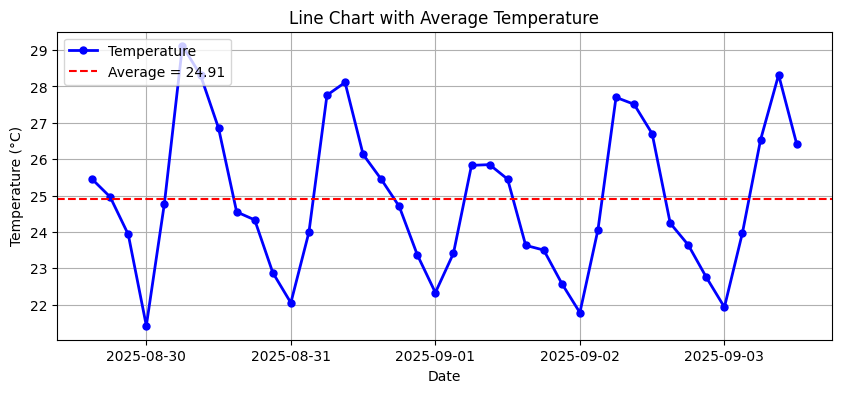

In [26]:
plt.figure(figsize=(10, 4))

# Line plot of temperature over time
plt.plot(df['date_time'], df['temperature'], 
         color='b', linestyle='-', linewidth=2, 
         marker='o', markersize=5, label='Temperature')

# Add average temperature line
average_value = df['temperature'].mean()
plt.axhline(y=average_value, color='r', linestyle='--', 
            label=f'Average = {average_value:.2f}')

# Labels and title
plt.title('Line Chart with Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')

# Legend and grid
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.show()


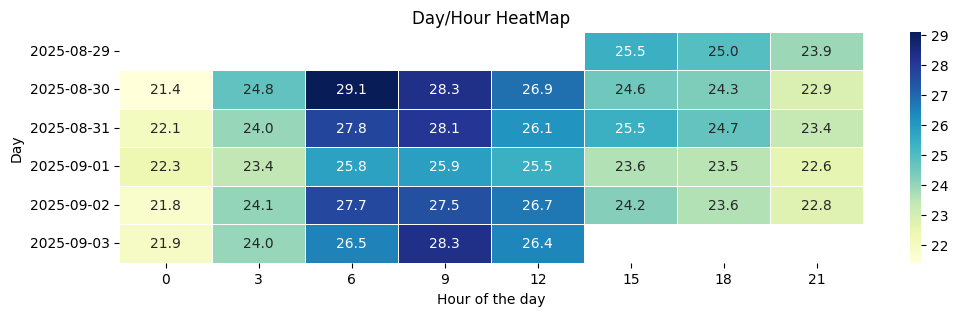

In [27]:
plt.figure(figsize=(12,3))
sns.heatmap(df_pivot,cmap='YlGnBu',annot=True,fmt=".1f",linewidth=.5)
plt.title('Day/Hour HeatMap')
plt.xlabel('Hour of the day')
plt.ylabel('Day')
plt.show()

## Load

Store the processed data into a PostgreSQL database.

In [28]:
import psycopg2
from sqlalchemy import create_engine

In [34]:
password=int(input())

In [ ]:
db_username='postgres'
db_password=password
db_host='localhost'
db_port=5432
db_name='postgres'

In [32]:
engine=create_engine(f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

In [33]:
table_name='weather'
df.to_sql(table_name,engine,if_exists='replace',index=False)
engine.dispose()

# ETL Pipeline Summary

- **Extract:** Weather data was fetched live from the OpenWeatherMap API.
- **Transform:** Data was cleaned, converted to Celsius, and visualized with line and heatmap plots.
- **Load:** The final DataFrame was loaded into a PostgreSQL database table named `weather`.

This notebook demonstrates a complete, live ETL workflow suitable for real-world data engineering projects.

**ETL Flow:**

Extract (API) → Transform (Pandas, Plots) → Load (PostgreSQL)